In [70]:
import os, glob
import numpy as np
import pandas as pd
from scipy import stats
from datetime import date, time, datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import np_utils
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,  accuracy_score
from keras.models import load_model
from sklearn.metrics import mean_squared_error
w_list= glob.glob("../result/merge_weather/*.csv")
p_list = glob.glob("../result/flower_price_byweek/*")
select_t = [(1,0),(3,2),(2,1),(2,3),(2,4)]
print(w_list)

['../result/merge_weather\\467480_嘉義.csv', '../result/merge_weather\\C0F9L0_后里.csv', '../result/merge_weather\\C0K490_古坑.csv', '../result/merge_weather\\C0X060_下營.csv']


In [2]:
class fp_pre:
    def __init__(self,fn_weather, fn_price):
        self.r_data = pd.read_csv(fn_weather, encoding="utf-8")
        self.lc_d = pd.read_csv("../lunar_done_new.csv", encoding="utf-8")
        self.df_pbw = pd.read_csv(fn_price, encoding="utf-8")
        self.d_data = self.r_data["Date"]
        self.flower_name = fn_price.split("\\")[-1].split("_")[0]
        self.station_name = fn_weather.split("\\")[-1].split("_")[0]
    
    def market_select(self, market):
        self.df_pbw = self.df_pbw.groupby("market").get_group(market)
    
    def prep_rdata(self):
        r_data = self.r_data
        col_fix =  ['T.Max', 'T.Min', 'Precp','Temperature', 'RH', 'StnPres', 'WS', 'WSGust']
        for col in col_fix:
            old = r_data[col]
            new = []
            for i in range(len(old)):
                try:
                    new.append(float(old[i]))
                    tmp = float(old[i])
                except ValueError:
                    new.append(tmp)
            r_data[col] = new
        d_tmp = r_data['T.Max'] - r_data['T.Min']
        r_data["d_tmp"]= d_tmp
        drop_c =["Date",'T.Max', 'T.Min']
        r_data = r_data.drop(columns=drop_c)
        
        def to_zscore(df):
            col_x = df.columns.to_list()
            mean = df.mean(axis=0)
            std = df.std(axis=0)
            for i in range(len(col_x)):
                df[col_x[i]]=(df[col_x[i]]-mean[i])/std[i]
            return  df , [list(mean), list(std)]
        r_data, self.recordz = to_zscore(r_data)
        self.r_data = r_data
        self.r_data_pre_done = r_data
    
    
    def join_lunar(self):
        self.r_data["Date"] = self.d_data
        self.r_data = self.r_data.join(self.lc_d.set_index("date"), on="Date")
        self.r_data = self.r_data.drop(columns="Date")
    
    
    def shift_rdata(self, shift1, shift2):
        dfs =[]
        arr_all =[]
        if shift2==0:
            df_s = self.r_data.copy()
        else:
            df_s = self.r_data.copy()
            df_s = df_s.shift(periods=shift2)
        arr_all = np.array(df_s)

        for i in range(1,shift1):
            tp = np.array(df_s.shift(periods=i))
            arr_all = np.concatenate((arr_all, tp), axis=1)
        df_all = pd.DataFrame(arr_all)
        df_all["date"] = self.d_data
        df_all = df_all.dropna()
        df_all = df_all.reset_index()
        df_all = df_all.drop(columns="index")
        self.d_data = df_all["date"]
        self.r_data = df_all
    
    
    def cutyw_rdata(self):
        def trans_to_y_w(d_date):
            year = int(d_date.split("-")[0])
            d_day = date(year,int(d_date.split("-")[1]), int(d_date.split("-")[2]))- date(year, 1, 1)
            d_w = 1+ (d_day.days // 7)
            if d_w ==53:
                d_w = 52
            result =  str(year) + "_" + str(d_w)

            if d_day.days % 7 ==6:
                return result
            else:
                return np.nan
        y_w = []
        for i in range(len(self.d_data)):
            y_w.append(trans_to_y_w(self.d_data[i]))
        self.r_data["y_w"] = y_w
        self.r_data_n_drop = self.r_data.copy()
        self.r_data = self.r_data.dropna()
        self.r_data = self.r_data.reset_index(drop=True)
#         self.r_data = self.r_data.drop(columns="index")
    
    
    def join_pbw_r_data(self):
        df_join = self.df_pbw.join(self.r_data.set_index("y_w"), on="y_w")
        df_join = df_join.dropna()
        df_join = df_join.reset_index(drop=True)
#         df_join = df_join.drop(columns="index")
        self.d_data = df_join["date"]
        self.r_data = df_join
    
    
    def dummy_market(self,d_t_dummy):
        tmp_dum = pd.DataFrame()
        for col in d_t_dummy:
            tmp_dum[col] = self.r_data[col]
            dummy = pd.get_dummies(tmp_dum[col])
            self.r_data = pd.concat([self.r_data, dummy], axis=1)
        self.r_data = self.r_data.drop(columns=d_t_dummy)
        self.x = self.r_data
        self.dummy = dummy
#         [,"year", "week","w_avg", "w_sale", "date", "y_w", "price_diff"]
    
    
    def drop_x_data(self,drop_c):
        self.x_beforedrop = self.x
        self.y_raw_price = self.x["w_avg"]
        self.x = self.x.drop(columns=drop_c)
        self.input_units = self.x.shape[1]
        
    
    
    def all_prep(self, shift1, shift2,d_t_dummy):
        self.prep_rdata()
        self.join_lunar()
        self.shift_rdata(shift1, shift2)
        self.shift1 = shift1
        self.shift2 = shift2
        self.cutyw_rdata()
        self.join_pbw_r_data()
        self.dummy_market(d_t_dummy)
        self.extract_xy()
        
    def all_prep_market_select(self, shift1, shift2,d_t_dummy,market):
        self.market_select(market)
        self.prep_rdata()
        self.join_lunar()
        self.shift_rdata(shift1, shift2)
        self.shift1 = shift1
        self.shift2 = shift2
        self.cutyw_rdata()
        self.join_pbw_r_data()
        self.dummy_market(d_t_dummy)
        self.extract_xy()
    
    def all_prep_nolunar(self, shift1, shift2,d_t_dummy):
        self.prep_rdata()
#         self.join_lunar()
        self.shift_rdata(shift1, shift2)
        self.shift1 = shift1
        self.shift2 = shift2
        self.cutyw_rdata()
        self.join_pbw_r_data()
        self.dummy_market(d_t_dummy)
        self.extract_xy()
    
    def extract_xy(self):
#     y_date = df_join["date"]
        self.y_yw = self.r_data["y_w"]
        self.y_raw = np.array(self.r_data["price_diff"])
        self.y_diff_d = np.array(self.r_data["w_avg"].diff())
        
    def split_y_to_class(self, input_y, list_y_class=[0]):
        y_class = []
        for i in range(len(input_y)):
            c = 0
            y = input_y[i]
            for j in range(len(list_y_class)):
                if y > list_y_class[j]:
                    c = c +1
            y_class.append(c)
#         print((np.bincount(y_class), list_y_class))
        self.output_class = len(np.bincount(y_class))
        return np.array(y_class)
    
    def y_to_class(self, list_y_class=[-0.1,0,0.1]):
        y_raw = self.y_raw
        self.y_list_class = list_y_class
        y_class = []
        for i in range(len(y_raw)):
            c = 0
            y = y_raw[i]
            for j in range(len(list_y_class)):
                if y > list_y_class[j]:
                    c = c +1
            y_class.append(c)
        self.y_class = np.array(y_class)
        self.y_freq = (np.bincount(y_class), list_y_class)
        self.output_class =len(np.bincount(y_class))
    
    
    def split_data(self, year,year_s=0):
        y_w = self.y_yw
        y_raw = self.y_raw
        y_year = []
        for  i in range(len(y_w)):
            y_year.append(int(y_w[i].split("_")[0]))
        y_year = np.array(y_year)
        self.split_info = np.unique(np.array(y_year), return_counts=True)
#         b_train = y_year[:]<=year
#         b_test = y_year[:]>year
#         delete data before year_s
        b_train = (y_year[:]<=year) * (y_year[:]>=year_s)
        b_test = (y_year[:]>year) * (y_year[:]>=year_s)
        x = np.array(self.x)
        y = np.array(self.y_class)
        self.split_xy = (x[b_train,:], y[b_train] , x[b_test,:], y[b_test])
        self.split_xy_count = (x[b_train,:], y_raw[b_train] , x[b_test,:], y_raw[b_test])
    
    def model_build(self, dinp=5):
        x_train, y_train, x_test, y_test = self.split_xy
        model = Sequential()
        layer_0 = Dense(units =self.input_units//dinp, input_dim = self.input_units,
                        kernel_initializer = "random_normal", activation = "relu")
        model.add(layer_0)
        model.add(Dropout(0.35))
        layer_1 = Dense(units =self.input_units//(dinp*5),
                        kernel_initializer = "random_normal", activation = "relu")
        model.add(layer_1)
        model.add(Dropout(0.35))
#         layer_1 = Dense(units =(self.shift1+1),kernel_initializer = "random_normal", activation = "relu")
#         model.add(layer_1)
#         model.add(Dropout(0.25))
        layer_out = Dense(units = self.output_class,kernel_initializer = "random_normal", 
                          activation = "softmax")
        model.add(layer_out)
        #     model.summary()
        model.compile(loss="categorical_crossentropy",optimizer = "adam", metrics = ['accuracy'])
        self.train_model = model

    def model_test(self, epochs=10):
        x_train, y_train, x_test, y_test = self.split_xy
        x_train, x_train_d, y_train, y_train_d = train_test_split(x_train, y_train,  test_size=0.01, shuffle=True)
        train_history = self.train_model.fit(x = x_train, y = np_utils.to_categorical(y_train), 
                                             validation_split = 0.2, epochs =epochs, verbose = 0)
        pre = self.train_model.predict_classes(x_test)
        acc = round(accuracy_score(y_test, pre)*100,2)
        test_result =  (pre , y_test)
        in_acc = round(accuracy_score(self.train_model.predict_classes(x_train), y_train)*100,2)
        train_result = (self.train_model.predict_classes(x_train), y_train)
        return acc,test_result, in_acc,train_result

In [64]:
model_info = {}
w_list= glob.glob("../result/merge_weather/*.csv")
p_list = glob.glob("../result/flower_price_byweek/*")
select_t = [(1,0),(3,2),(2,1),(2,3),(2,4)]
st, flower = select_t[3]
fn_weather = w_list[st]
fn_price = p_list[flower]
print(fn_weather, fn_price)
fp = fp_pre(fn_weather, fn_price)
drop_c = ["year","w_avg", "w_sale", "date", "y_w", "price_diff"]
d_t_dummy = ["market","week"]
# fp.all_prep(12,1,d_t_dummy)
fp.all_prep(11,1,d_t_dummy)
fp.y_to_class([-0.1,0,0.1])
# fp.y_to_class([0])
fp.drop_x_data(drop_c)
fp.x.shape,fp.y_yw.shape,fp.y_class.shape
model = load_model("./flower_pre_model/04_model/OrientalLily_C0K490_11_1_c4.h5")
# model = load_model("./flower_pre_model/01_model/OrientalLily_C0K490_12_1.h5")
# x_train, y_train, x_test, y_test = fp.split_xy
pre  = model.predict_classes(fp.x)


../result/merge_weather\C0K490_古坑.csv ../result/flower_price_byweek\OrientalLily_pbyweek.csv


In [51]:
# df_m = pd.DataFrame()
# m_list = ["台中", "台北", "台南", "彰化", "高雄"]
# for m in m_list:
#     df[m] = fp.x[m]
# df_m.head()

In [85]:
df = pd.DataFrame()
df["pre"]=pre
# df["y_yw"]=fp.y_yw
df["ans"]=fp.y_class
df["price"]=fp.y_raw_price
df["date"] = fp.d_data
m_list = ["台中", "台北", "台南", "彰化", "高雄"]
for m in m_list:
    df[m] = fp.x[m]
df.head()

,pre,ans,price,date,台中,台北,台南,彰化,高雄
0,0,0,129.124291,2015-07-08,1,0,0,0,0
1,1,1,127.155004,2015-07-15,1,0,0,0,0
2,2,2,127.770897,2015-07-22,1,0,0,0,0
3,3,3,173.655904,2015-07-29,1,0,0,0,0
4,3,3,219.573682,2015-08-05,1,0,0,0,0


2359.4968446924395


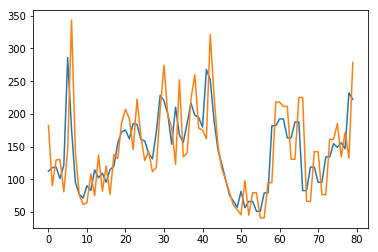

In [105]:
df = pd.DataFrame()
df["pre"]=pre
# df["y_yw"]=fp.y_yw
df["ans"]=fp.y_class
df["price"]=fp.y_raw_price
df["date"] = fp.d_data
m_list = ["台中", "台北", "台南", "彰化", "高雄"]
for m in m_list:
    df[m] = fp.x[m]
# df.to_csv("result_to_plot.csv", index=False)
# df.to_csv("test0529.csv",index=False)
price = np.array(df["price"])
pre  = np.array(df["pre"])
pre_price = []

c = [0.9,0.95,1.05,1.1]
for i in range(len(price)):
    pre_price.append(price[i]*c[pre[i]])
df["pre_price"]=pre_price
df["pre_price"] = df["pre_price"].shift(periods=1)
# df.head(5)
arr = np.array(df)
arr = arr[arr[:,7]==1]
arr = arr[-80:]
df_m_s= pd.DataFrame(arr,columns=df.columns.to_list())
df_m_s
df_new = df_m_s[["price", "pre_price"]]
mse = mean_squared_error(df_new["price"], df_new["pre_price"])
print(mse)
# if mse < best_mse:
#     best_mse = mse
#     best_t = t/1000
#     print(mean_squared_error(df_new["price"], df_new["pre_price"]))
# best_t
# print(best_mse, best_t)
# arr = arr[:,0:4]
plt.plot(range(len(df_new)),df_new["price"])
plt.plot(range(len(df_new)),df_new["pre_price"])
# df_new.head()

1.0

In [110]:
df.head(20)
# m = m_list[0]
arr = np.array(df)
# select m 
arr = arr[arr[:,5]==1]
arr = arr[:,0:4]
arr[0:5,:]

array([[1, 0, 146.91049605698296, '2015-07-08'],
       [1, 0, 141.08346455792685, '2015-07-15'],
       [1, 1, 158.4296317829457, '2015-07-22'],
       [0, 1, 177.65942431167701, '2015-07-29'],
       [1, 1, 217.57051740812375, '2015-08-05']], dtype=object)

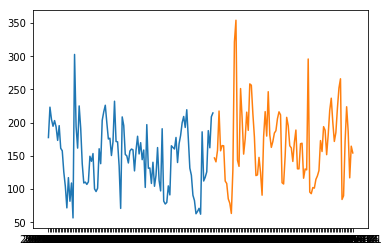

In [116]:
# arr = np.array(df)
green = arr[arr[:,0]==0]
red = arr[arr[:,0]==1]
plt.plot(green[:,3],green[:,2])
plt.plot(red[:,3],red[:,2])

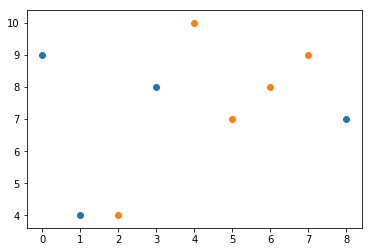

In [121]:
plt.scatter([0,1,3,8],[9,4,8,7])
plt.scatter([2,4,5,6,7],[4,10,7,8,9])

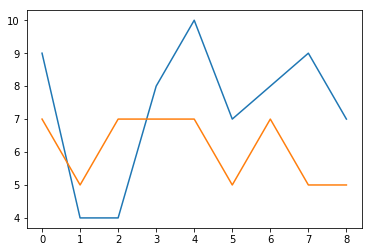

In [129]:
plt.plot(range(9),[9,4,4,8,10,7,8,9,7])
plt.plot(range(9),[7,5,7,7,7,5,7,5,5])

In [1]:
# model_info = {}
# w_list= glob.glob("../result/merge_weather/*.csv")
# p_list = glob.glob("../result/flower_price_byweek/*")
# select_t = [(1,0),(3,2),(2,1),(2,3),(2,4)]
# st, flower = select_t[3]
# fn_weather = w_list[st]
# fn_price = p_list[flower]
# fp = fp_pre(fn_weather, fn_price)
# model_info["flower"]= fp.flower_name
# model_info["station"]= fp.station_name
# drop_c = ["year","w_avg", "w_sale", "date", "y_w", "price_diff"]
# d_t_dummy = ["market"]
# fp.all_prep(1,1,d_t_dummy)
# fp.dummy

In [2]:
# w_list= glob.glob("../result/merge_weather/*.csv")
# p_list = glob.glob("../result/flower_price_byweek/*")
# # st = 0
# records = pd.DataFrame()
# for st in range(4):
#     fn_weather = w_list[st]
#     st_n  = fn_weather.split("\\")[-1].split("_")[0]
#     fn_price = p_list[0]
#     print(fn_weather, fn_price)
#     fp = fp_pre(fn_weather, fn_price)
#     fp.prep_rdata()
#     records[st_n] = fp.recordz
# records
# records.to_csv("./flower_pre_model/weather_trans.csv", index=False)

In [21]:
def main_model_run(select,year_split,shift1, shift2, list_split_y):
#     class_y_diff =[0]
    model_info = {}
    w_list= glob.glob("../result/merge_weather/*.csv")
    p_list = glob.glob("../result/flower_price_byweek/*")
    select_t = [(1,0),(3,2),(2,1),(2,3),(2,4)]
    st, flower = select_t[select]
    fn_weather = w_list[st]
    fn_price = p_list[flower]
    fp = fp_pre(fn_weather, fn_price)
    model_info["flower"]= fp.flower_name
    model_info["station"]= fp.station_name
    drop_c = ["year","w_avg", "w_sale", "date", "y_w", "price_diff"]
    d_t_dummy = ["market", "week"]
    fp.all_prep(shift1, shift2,d_t_dummy)
#     fp.y_to_class(list_split_y)
    fp.y_to_class(list_split_y)
    fp.drop_x_data(drop_c)
    
    fp.split_data(year_split)
    model_info["weather_trans"] = fp.recordz
    model_info["shift"] = (shift1, shift2)
    dinp = 5
    acc = []
    epo_cf = []
    acc_max = 0
    epochs = 3
    epochs_try =20
    plot_x = []
    fp.model_build(dinp)
    test_acc = []
    train_acc = []
    #         print(epochs, end="\t")
    for i in range(epochs_try):
        t_acc , test_result, in_acc,train_result= fp.model_test(epochs)
        acc.append(t_acc)
        if t_acc>acc_max and in_acc>50:
            acc_max = t_acc
            best_test = test_result
            in_acc_max  = in_acc
            best_train = train_result
            best_epochs = epochs*(i+1)
            best_mode = fp.train_model
        test_acc.append(t_acc)
        train_acc.append(in_acc)
    model_info["acc_info"] = [acc_max, in_acc_max, best_epochs]
#     model_info.append(best_mode)
    return model_info, best_mode

In [27]:
all_model_data =[]
save_path = "./flower_pre_model/04_model/"
select = 0
year_split = 2018
shift1 = 7
shift2 = 1

list_split_y = [-0.1,0,0.1]
for shift2 in [1,8,15]: # [1,8,15]:
    for select in range(5): 
        best_test_acc = 0 
        for shift1 in range(7,16,2):
            records , best_model= main_model_run(select,year_split,shift1, shift2, list_split_y)
            model_fn = save_path + "_".join((records["flower"], records["station"], str(records["shift"][0]),
                                             str(records["shift"][1]))) + "_c4.h5"
            model_data  = [records["flower"], records["station"], str(records["shift"][0]),
                           str(records["shift"][1]), records['acc_info'][0], records['acc_info'][1]]
            if best_test_acc< records['acc_info'][0]:
                best_test_acc = records['acc_info'][0]
                best_model_save = best_model
                best_model_fn = model_fn
            all_model_data.append(model_data)
            
        best_model_save.save(best_model_fn)
pd.DataFrame(all_model_data, columns=["flower", "station", "shift1", "shift2", "test_acc", "train_acc"])

,flower,station,shift1,shift2,test_acc,train_acc
0,Anthurium,C0F9L0,7,1,36.30,57.94
1,Anthurium,C0F9L0,9,1,31.85,57.86
2,Anthurium,C0F9L0,11,1,34.81,59.20
3,Anthurium,C0F9L0,13,1,38.52,59.28
4,Anthurium,C0F9L0,15,1,39.26,58.41
5,Eustoma,C0X060,7,1,39.29,54.00
6,Eustoma,C0X060,9,1,20.71,50.44
7,Eustoma,C0X060,11,1,25.71,60.67
8,Eustoma,C0X060,13,1,31.43,60.22
9,Eustoma,C0X060,15,1,39.29,51.17


In [30]:
# records
df = pd.DataFrame(all_model_data, columns=["flower", "station", "shift1", "shift2", "test_acc", "train_acc"])
df.to_csv("./flower_pre_model/04_model/result.csv", index=False, encoding="utf-8")

In [106]:
df.columns.to_list()

['flower', 'station', 'shift1', 'shift2', 'test_acc', 'train_acc']

In [32]:
df = pd.DataFrame(all_model_data, columns=["flower", "station", "shift1", "shift2", "test_acc", "train_acc"])
g = df.groupby(["flower","shift2"])
best_data = []
for flower in ["Anthurium", "Eustoma", "Chrysanthemum","OrientalLily","Rose"]:
    for sh2 in ["1","8","15"]:
        df_t = g.get_group((flower,sh2))
        best_data.append(list(df_t.loc[df_t['test_acc'].idxmax()]))
df_b = pd.DataFrame(best_data, columns=['flower', 'station', 'shift1', 'shift2', 'test_acc', 'train_acc'])
df_b

,flower,station,shift1,shift2,test_acc,train_acc
0,Anthurium,C0F9L0,15,1,39.26,58.41
1,Anthurium,C0F9L0,13,8,45.19,53.43
2,Anthurium,C0F9L0,9,15,49.63,58.56
3,Eustoma,C0X060,7,1,39.29,54.00
4,Eustoma,C0X060,11,8,45.00,53.85
5,Eustoma,C0X060,9,15,51.43,53.76
6,Chrysanthemum,C0K490,7,1,42.14,62.62
7,Chrysanthemum,C0K490,13,8,35.71,70.22
8,Chrysanthemum,C0K490,7,15,38.57,62.10
9,OrientalLily,C0K490,11,1,54.29,74.64


In [33]:
df_b.to_csv("./flower_pre_model/04_model/result_best.csv", index=False, encoding="utf-8")

In [29]:
# select = 0
# year_split = 2018
# shift1 = 7
# shift2 = 1
# list_split_y = [0]
# model_info = []
# w_list= glob.glob("../result/merge_weather/*.csv")
# p_list = glob.glob("../result/flower_price_byweek/*")
# select_t = [(1,0),(3,2),(2,1),(2,3),(2,4)]
# st, flower = select_t[select]
# fn_weather = w_list[st]
# fn_price = p_list[flower]
# fp = fp_pre(fn_weather, fn_price)
# model_info.append(fp.flower_name)
# drop_c = ["year","w_avg", "w_sale", "date", "y_w", "price_diff"]
# d_t_dummy = ["market", "week"]
# fp.all_prep(shift1, shift2,d_t_dummy)
# fp.y_to_class(list_split_y)
# fp.drop_x_data(drop_c)
# fp.split_data(year_split, year_s)


In [28]:
# main_model_run(select,year_split,shift1, shift2, class_y_diff)



In [5]:
# flower test train ep class
# Anthurium
# 64.44 51.78 3
# Eustoma
# 35.71 63.69 39
# Chrysanthemum
# 20.71 66.48 21
# OrientalLily
# 30.0 78.13 60
# Rose
# 30.71 65.6 12

# +8d
# Anthurium
# 62.22 72.82 12
# Eustoma
# 33.57 71.83 114
# Chrysanthemum
# 29.29 68.4 24
# OrientalLily
# 28.57 64.53 9
# Rose
# 30.0 71.05 27






# [-25%,50%,75%]
# Anthurium
# 台北	70.37 50.2 3
# 台中	62.96 50.59 3
# 高雄	70.37 57.71 21
# 台南	74.07 55.34 21
# 彰化	66.67 51.78 6
# Eustoma
# 台北	50.0 68.72 27
# 台中	25.0 66.48 27
# 高雄	32.14 100.0 72
# 台南	21.43 59.78 18
# 彰化	28.57 100.0 81
# Chrysanthemum
# 台北	28.57 100.0 63
# 台中	46.43 95.6 51
# 高雄	25.0 64.84 21
# 台南	35.71 57.14 21
# 彰化	21.43 100.0 66
# OrientalLily
# 台北	35.71 96.7 51
# 台中	39.29 75.27 30
# 高雄	42.86 59.89 24
# 台南	28.57 95.6 42
# 彰化	32.14 73.63 36
# Rose
# 台北	28.57 100.0 69
# 台中	28.57 59.34 27
# 高雄	32.14 100.0 69
# 台南	32.14 100.0 120
# 彰化	35.71 50.55 15

# [0]
# Anthurium
# 64.44 64.25 3
# Eustoma
# 55.0 61.56 3
# Chrysanthemum
# 59.29 63.08 3
# OrientalLily
# 67.14 80.0 6
# Rose
# 55.71 86.26 9

# Anthurium
# 台北	70.37 82.21 15
# 台中	70.37 62.45 6
# 高雄	62.96 74.31 15
# 台南	59.26 98.02 33
# 彰化	66.67 62.45 9
# Eustoma
# 台北	64.29 100.0 81
# 台中	64.29 74.3 12
# 高雄	60.71 100.0 66
# 台南	42.86 59.22 6
# 彰化	64.29 64.8 3
# Chrysanthemum
# 台北	78.57 63.19 6
# 台中	67.86 97.8 36
# 高雄	57.14 54.95 3
# 台南	50.0 61.54 3
# 彰化	64.29 52.75 3
# OrientalLily
# 台北	64.29 80.22 15
# 台中	71.43 94.51 27
# 高雄	75.0 88.46 24
# 台南	71.43 55.49 3
# 彰化	67.86 100.0 120
# Rose
# 台北	53.57 85.71 18
# 台中	50.0 100.0 66
# 高雄	60.71 68.68 9
# 台南	64.29 100.0 48
# 彰化	67.86 100.0 57

In [6]:
# 花名 測站名稱 shift (參數,預測週(1,8,15), 準確率範圍)
# Anthurium 467480     shift:(14,1,55~63%), (27,8,46~65%) (19,15,55~72%)
# Chrysanthemum C0F9L0 shift:(19,1,51~58%), (16,8,40~59%) (16,15,33~50%)
# Eustoma C0F9L0       shift:(3,1,67~73%) (16,8,49~57%) (12,15,51~63%)  epochs [10,]
# OrientalLily C0X060  shift:(17,1,77~79%) (22,8,66~75%) (14,15,43~64%) epochs [ , 12, ]
# Rose C0X060          shift:(7,1,47~64%) (18,8,42~64%) (18,15,55~69%)